In [9]:
:dep anyhow = "1.0.66"
:dep opencv = "0.70.0"
:dep image = "0.23"
:dep evcxr_image = "1.1.0"
:dep ndarray = "0.15.6"
:dep nalgebra = "0.31.2"

use std::fs;
use std::path::{Path};
use anyhow::{anyhow, Result, Error};
use opencv::prelude::*;
use image::{ImageBuffer, RgbImage, Rgb};
use evcxr_image::ImageDisplay;

#[macro_use]
extern crate nalgebra as na;

fn opencv_imshow(img: &Mat) {
    let img_rgb = RgbImage::new(img.cols() as u32, img.rows() as u32);
    let data: Vec<u8> = img.data_bytes().unwrap().to_vec();
    let channels: u32 = img.channels() as u32;
    image::ImageBuffer::from_fn(img_rgb.width(), img_rgb.height(), | x, y | {
        let yi = y * img_rgb.width();
        let i: usize = ((x + yi) * channels) as usize;
        match channels {
            3 => {
                let b = data[i];
                let g = data[i + 1];
                let r = data[i + 2];
                image::Rgb([r, g, b])
            },
            _ => {
                let b = data[i];
                image::Rgb([b, b, b])
            }
        }
    }).evcxr_display()
}

let image_dir = "/home/cloud-user/workspace/KU15627-Computer-Vision/images";

# Hessian Corner Detector

Mat { type: "CV_8UC1", flags: 1124024320, channels: 1, depth: "CV_8U", dims: 2, size: Size_ { width: 900, height: 1200 }, rows: 1200, cols: 900, elem_size: 1, elem_size1: 1, total: 1080000, is_continuous: true, is_submatrix: false }


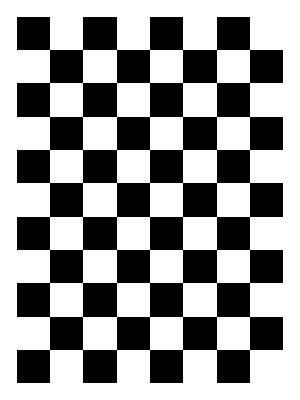

In [111]:
let image_path = Path::new(image_dir).join("checkerboard.png");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
println!("{:?}", &img);
let mut img_resized: Mat = Default::default();
opencv::imgproc::resize(
    &img,
    &mut img_resized,
    opencv::core::Size::new(300, 400),
    0., // fx. default 0.
    0., // fy. default 0.
    opencv::imgproc::INTER_LINEAR as i32
);
opencv_imshow(&img_resized)

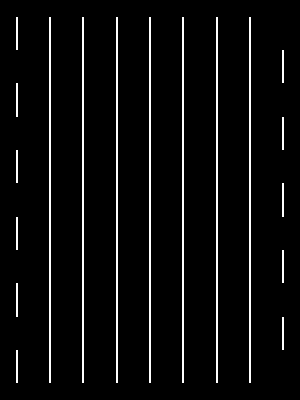

In [112]:
let mut img_filter2d_Ixx: Mat = Default::default();
let kernel_Ixx: Mat = Mat::from_slice_2d(&[[0. as f32, 0., 0.], [1., -2., 1.], [0., 0., 0.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_resized,
    &mut img_filter2d_Ixx,
    opencv::core::CV_32FC1,
    &kernel_Ixx,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_Ixx_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_Ixx, &mut img_filter2d_Ixx_abs, 1., 0.);
opencv_imshow(&img_filter2d_Ixx_abs)

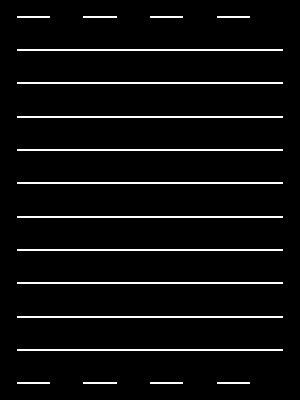

In [113]:
let mut img_filter2d_Iyy: Mat = Default::default();
let kernel_Iyy: Mat = Mat::from_slice_2d(&[[0. as f32, 1., 0.], [0., -2., 0.], [0., 1., 0.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_resized,
    &mut img_filter2d_Iyy,
    opencv::core::CV_32FC1,
    &kernel_Iyy,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_Iyy_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_Iyy, &mut img_filter2d_Iyy_abs, 1., 0.);
opencv_imshow(&img_filter2d_Iyy_abs)

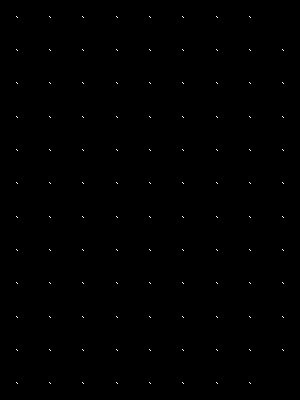

In [114]:
let mut img_filter2d_Ixy: Mat = Default::default();
let kernel_Ixy: Mat = Mat::from_slice_2d(&[[1. as f32, -1., 0.], [-1., 2., -1.], [0., -1., 1.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_resized,
    &mut img_filter2d_Ixy,
    opencv::core::CV_32FC1,
    &kernel_Ixy,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_Ixy_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_Ixy, &mut img_filter2d_Ixy_abs, 1., 0.);
opencv_imshow(&img_filter2d_Ixy_abs)

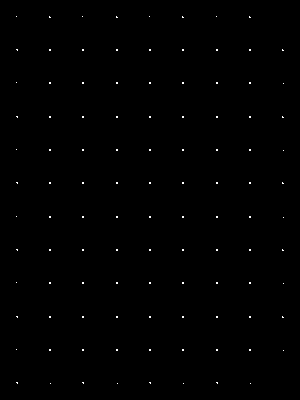

In [115]:
// same as img_filter2d_Ixx_abs*img_filter2d_Iyy_abs - img_filter2d_Ixy_abs**2
let mut img_filter2d_Ixxyy_multi: Mat = Default::default();
opencv::core::multiply(&img_filter2d_Ixx, &img_filter2d_Iyy, &mut img_filter2d_Ixxyy_multi, 1., -1);

let mut img_filter2d_Ixy_pow: Mat = Default::default();
opencv::core::multiply(&img_filter2d_Ixy, &img_filter2d_Ixy, &mut img_filter2d_Ixy_pow, 1., -1);

let mut img_filter2d_detH: Mat = Default::default();
opencv::core::subtract(
    &img_filter2d_Ixxyy_multi,
    &img_filter2d_Ixy_pow,
    &mut img_filter2d_detH,
    &opencv::core::no_array(),
    -1
);
let mut img_filter2d_detH_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_detH, &mut img_filter2d_detH_abs, 1., 0.);
opencv_imshow(&img_filter2d_detH_abs)

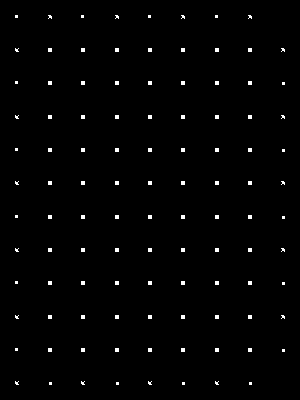

In [116]:
let mut img_filter2d_corner: Mat = Default::default();
let kernel_corner: Mat = Mat::from_slice_2d(&[[-1. as f32, -1., -1.], [-1., 8., -1.], [-1., -1., -1.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_filter2d_detH,
    &mut img_filter2d_corner,
    opencv::core::CV_32FC1,
    &kernel_corner,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_corner_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_corner, &mut img_filter2d_corner_abs, 1., 0.);
opencv_imshow(&img_filter2d_corner_abs)

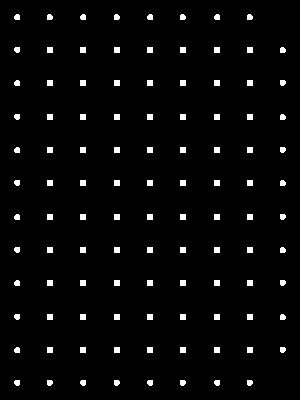

In [117]:
let mut img_resized_f32: Mat = Default::default();
img_resized.convert_to(&mut img_resized_f32, opencv::core::CV_32FC1, 1., 0.);
let mut img_corner_harris: Mat = Default::default();
opencv::imgproc::corner_harris(
    &img_resized_f32,
    &mut img_corner_harris,
    3, // block_size
    3, // ksize
    0.04, //k
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_corner_harris_dilate: Mat = Default::default();
opencv::imgproc::dilate(
    &img_corner_harris,
    &mut img_corner_harris_dilate,
    &opencv::core::no_array(),
    opencv::core::Point::new(-1, -1),
    1, 0, Default::default()
);
let mut img_corner_harris_dilate_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris_dilate,
    &mut img_corner_harris_dilate_bin,
    0., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");

let mut img_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_dilate_bin, &mut img_corner_harris_abs, 1., 0.);
opencv_imshow(&img_corner_harris_abs)

# Harris Corner Detector

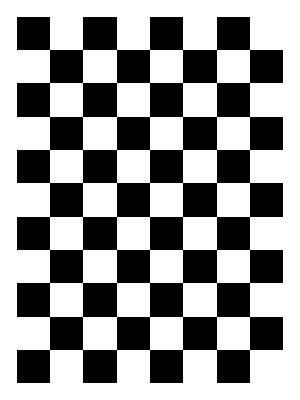

In [118]:
opencv_imshow(&img_resized)

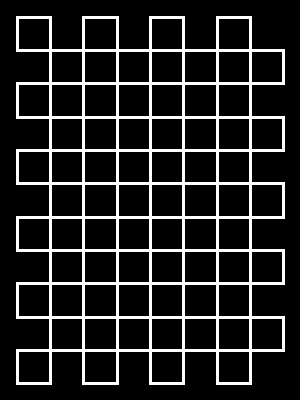

In [119]:
let mut img_resized_f32: Mat = Default::default();
img_resized.convert_to(&mut img_resized_f32, opencv::core::CV_32FC1, 1., 0.);
let mut img_corner_harris: Mat = Default::default();
opencv::imgproc::corner_harris(
    &img_resized_f32,
    &mut img_corner_harris,
    2, // block_size
    3, // ksize
    0.04, //k
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);

let mut img_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris, &mut img_corner_harris_abs, 1., 0.);
opencv_imshow(&img_corner_harris_abs)

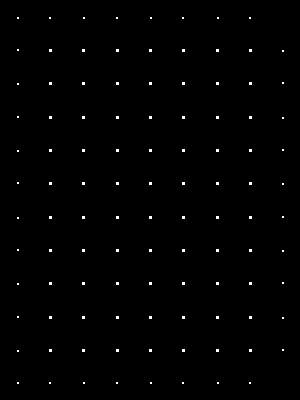

In [120]:
let mut img_corner_harris_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris,
    &mut img_corner_harris_bin,
    0., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");
let mut img_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_bin, &mut img_corner_harris_abs, 1., 0.);
opencv_imshow(&img_corner_harris_abs)

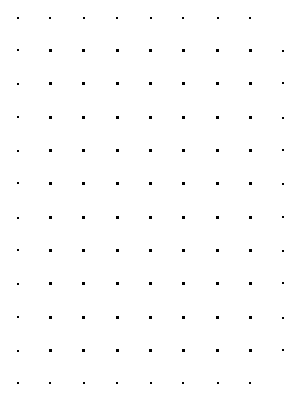

In [121]:
let mut img_corner_harris_bin_inv: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris,
    &mut img_corner_harris_bin_inv,
    0., 255., opencv::imgproc::THRESH_BINARY_INV).expect("threshold failed.");
let mut img_corner_harris_bin_inv_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_bin_inv, &mut img_corner_harris_bin_inv_abs, 1., 0.);
opencv_imshow(&img_corner_harris_bin_inv_abs)

# Hessian and Harris Corner

Mat { type: "CV_8UC1", flags: 1124024320, channels: 1, depth: "CV_8U", dims: 2, size: Size_ { width: 500, height: 375 }, rows: 375, cols: 500, elem_size: 1, elem_size1: 1, total: 187500, is_continuous: true, is_submatrix: false }


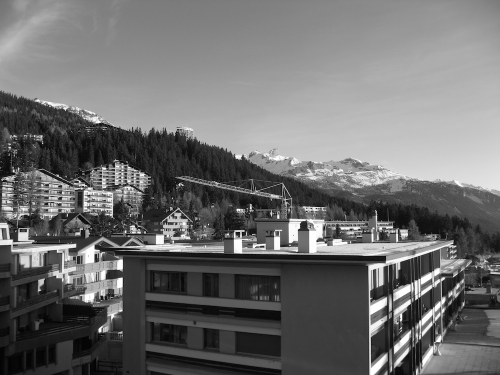

In [128]:
let image_path = Path::new(image_dir).join("crans_1_small.jpg");
let img_crans: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
let mut img_crans_resized: Mat = Default::default();
opencv::imgproc::resize(
    &img_crans,
    &mut img_crans_resized,
    opencv::core::Size::new(img_crans.cols() / 2, img_crans.rows() / 2),
    0., // fx. default 0.
    0., // fy. default 0.
    opencv::imgproc::INTER_LINEAR as i32
);
println!("{:?}", &img_crans_resized);
opencv_imshow(&img_crans_resized)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 500, height: 375 }, rows: 375, cols: 500, elem_size: 4, elem_size1: 4, total: 187500, is_continuous: true, is_submatrix: false }


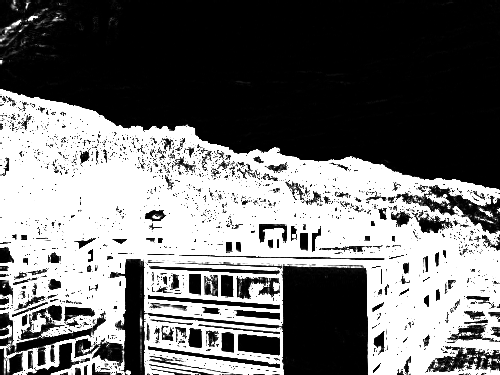

In [139]:
let mut img_crans_resized_f32: Mat = Default::default();
img_crans_resized.convert_to(&mut img_crans_resized_f32, opencv::core::CV_32FC1, 1., 0.);
println!("{:?}", &img_crans_resized_f32);
let mut img_crans_corner_harris: Mat = Default::default();
opencv::imgproc::corner_harris(
    &img_crans_resized_f32,
    &mut img_crans_corner_harris,
    2, // block_size
    3, // ksize
    0.04, //k
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);

let mut img_crans_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris, &mut img_crans_corner_harris_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_abs)

In [141]:
let mut img_crans_corner_harris_min: f64 = Default::default();
let img_crans_corner_harris_min_containter = Some(&mut img_crans_corner_harris_min);
let mut img_crans_corner_harris_max: f64 = Default::default();
let img_crans_corner_harris_max_containter = Some(&mut img_crans_corner_harris_max);
opencv::core::min_max_loc(
    &img_crans_corner_harris,
    img_crans_corner_harris_min_containter,
    img_crans_corner_harris_max_containter,
    None,
    None,
    &opencv::core::no_array()
);
println!("min: {:?}", &img_crans_corner_harris_min);
println!("max: {:?}", &img_crans_corner_harris_max);

min: -62114668.0
max: 132259176.0


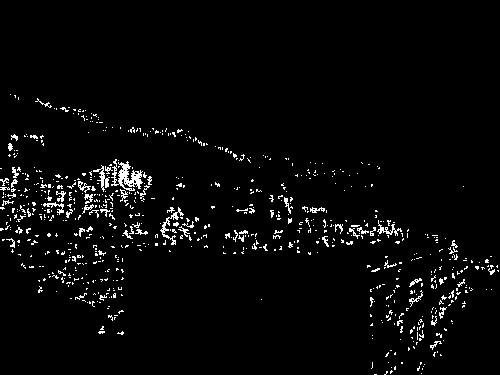

In [144]:
let mut img_crans_corner_harris_max_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_crans_corner_harris,
    &mut img_crans_corner_harris_max_bin,
    &img_crans_corner_harris_max * 0.01, 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");

let mut img_crans_corner_harris_max_bin_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris_max_bin, &mut img_crans_corner_harris_max_bin_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_max_bin_abs)

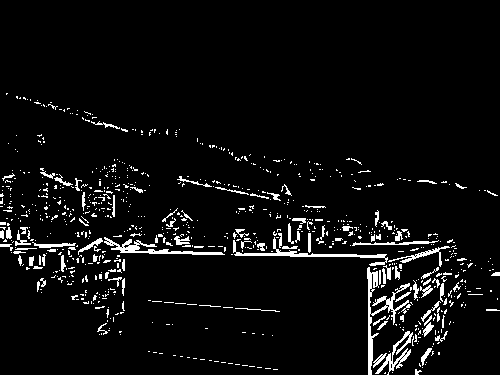

In [145]:
let mut img_crans_corner_harris_min_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_crans_corner_harris,
    &mut img_crans_corner_harris_min_bin,
    &img_crans_corner_harris_min * 0.01, 255., opencv::imgproc::THRESH_BINARY_INV).expect("threshold failed.");

let mut img_crans_corner_harris_min_bin_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris_min_bin, &mut img_crans_corner_harris_min_bin_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_min_bin_abs)

max: 255.0 / min: 0.0


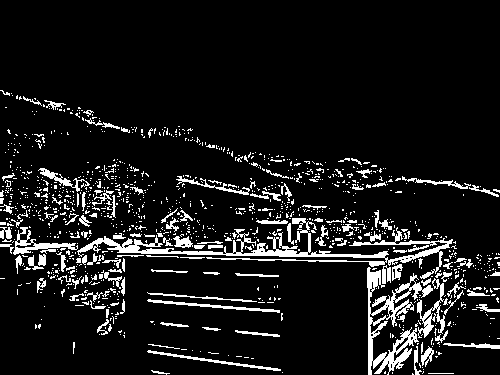

In [187]:
let mut img_crans_corner_harris_abs_f32: Mat = Default::default();
&img_crans_corner_harris_abs.convert_to(&mut img_crans_corner_harris_abs_f32, opencv::core::CV_32FC1, 1., 0.);
let mut img_crans_corner_harris_abs_f32_min: f64 = Default::default();
let img_crans_corner_harris_abs_f32_min_containter = Some(&mut img_crans_corner_harris_abs_f32_min);
let mut img_crans_corner_harris_abs_f32_max: f64 = Default::default();
let img_crans_corner_harris_abs_f32_max_containter = Some(&mut img_crans_corner_harris_abs_f32_max);
opencv::core::min_max_loc(
    &img_crans_corner_harris_abs_f32,
    img_crans_corner_harris_abs_f32_min_containter,
    img_crans_corner_harris_abs_f32_max_containter,
    None,
    None,
    &opencv::core::no_array()
);
println!("max: {:?} / min: {:?}", &img_crans_corner_harris_abs_f32_max, img_crans_corner_harris_abs_f32_min);

let mut img_crans_corner_harris_final_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_crans_corner_harris,
    &mut img_crans_corner_harris_final_bin,
    &img_crans_corner_harris_min * 0.001, 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");

let mut img_crans_corner_harris_final_bin_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris_final_bin, &mut img_crans_corner_harris_final_bin_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_final_bin_abs)